In [1]:
from google.colab import files
uploaded=files.upload()  # Use this in Colab to upload the file from your local system

!unzip ml-100k.zip  # Unzips the dataset


Saving ml-100k.zip to ml-100k.zip
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [2]:
import pandas as pd

# Load ratings data
ratings=pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Load movies data
movies=pd.read_csv('ml-100k/u.item', sep='|', encoding='ISO-8859-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], usecols=range(24))

print(ratings.head())
print(movies.head())


   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596
   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0    

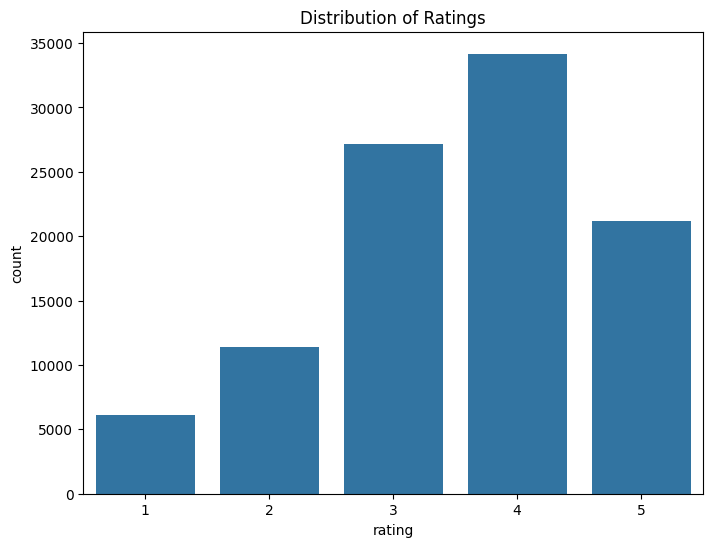

                           title  counts
0               Star Wars (1977)     583
1                 Contact (1997)     509
2                   Fargo (1996)     508
3      Return of the Jedi (1983)     507
4               Liar Liar (1997)     485
5    English Patient, The (1996)     481
6                  Scream (1996)     478
7               Toy Story (1995)     452
8           Air Force One (1997)     431
9  Independence Day (ID4) (1996)     429


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Rating distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

# Top 10 movies by number of ratings
top_movies=ratings['movie_id'].value_counts().head(10)
top_movies=pd.DataFrame({'movie_id': top_movies.index, 'counts': top_movies.values})
top_movies=top_movies.merge(movies, on='movie_id', how='left')
print(top_movies[['title', 'counts']])


In [4]:
# Check for missing values
print(ratings.isnull().sum())
print(movies.isnull().sum())

# Assuming 'rating' should be between 1 and 5
ratings=ratings[(ratings['rating'] >= 1) & (ratings['rating'] <= 5)]


user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
movie_id                 0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64


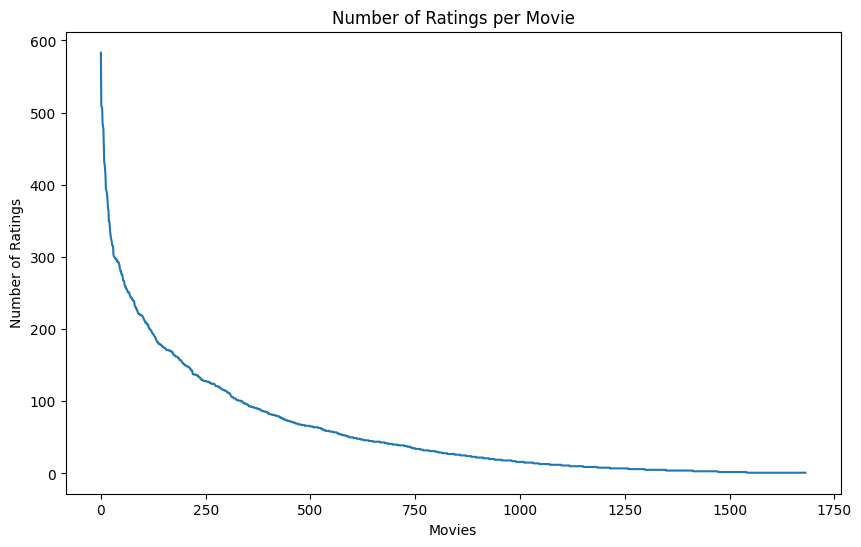

In [5]:
# Number of ratings per movie
ratings_per_movie=ratings['movie_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_movie.values)
plt.title('Number of Ratings per Movie')
plt.xlabel('Movies')
plt.ylabel('Number of Ratings')
plt.show()


In [ ]:

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]="/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
!pip install findspark
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark=SparkSession.builder.master("local[*]").appName("Movie Recommendation").getOrCreate()

# Schema definition for ratings
from pyspark.sql.types import StructType, StructField, IntegerType

schema=StructType([
    StructField("user_id", IntegerType(), True),
    StructField("movie_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)
])

# Load ratings data
ratings_df=spark.read.csv('/content/ml-100k/u.data', schema=schema, sep='\t')
ratings_df.show(5)

#ALS model and train it
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

als=ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)
model=als.fit(ratings_df)

#Evaluate the model
(training, test)=ratings_df.randomSplit([0.8, 0.2])
predictions=model.transform(test)
evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print("Root-mean-square error=" + str(rmse))

# Save the model
model.save("/content/drive/MyDrive/movie_recommender_model")

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|    196|     242|     3|881250949|
|    186|     302|     3|891717742|
|     22|     377|     1|878887116|
|    244|      51|     2|880606923|
|    166|     346|     1|886397596|
+-------+--------+------+---------+
only showing top 5 rows

Root-mean-square error = 0.738490554119528


In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Schema definition for the movies data
movies_schema=StructType([
    StructField("movie_id", IntegerType(), True),
    StructField("title", StringType(), True),
    # Assuming genres start from column index 5 to the end in your movies file
    StructField("genres", StringType(), True)  # Genres are concatenated in one column
])

# Now, read the movies data with the correct schema
movies_df=spark.read.csv('/content/ml-100k/u.item', schema=movies_schema, sep='|', encoding='ISO-8859-1')
movies_df.show(5)


+--------+-----------------+-----------+
|movie_id|            title|     genres|
+--------+-----------------+-----------+
|       1| Toy Story (1995)|01-Jan-1995|
|       2| GoldenEye (1995)|01-Jan-1995|
|       3|Four Rooms (1995)|01-Jan-1995|
|       4|Get Shorty (1995)|01-Jan-1995|
|       5|   Copycat (1995)|01-Jan-1995|
+--------+-----------------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col, udf, split
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import CountVectorizer

# Assuming 'movies_df' is loaded correctly with 'genres' as a single string
# Check the current schema to confirm the data types
movies_df.printSchema()

# If 'genres' is not an array, split it into an array
if isinstance(movies_df.schema["genres"].dataType, StringType):
    movies_df=movies_df.withColumn("genres", split(col("genres"), "\|"))

# Ensure there are no null or empty genre arrays
fix_empty_genres=udf(lambda x: x if x and len(x) > 0 else ["unknown"], ArrayType(StringType()))
movies_df=movies_df.withColumn("genres", fix_empty_genres(col("genres")))

# Vectorize the genres
vectorizer=CountVectorizer(inputCol="genres", outputCol="genre_features")
model=vectorizer.fit(movies_df)
movies_df=model.transform(movies_df)

# Show the transformed DataFrame
movies_df.select("movie_id", "title", "genre_features").show(5, truncate=False)


root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+--------+-----------------+---------------+
|movie_id|title            |genre_features |
+--------+-----------------+---------------+
|1       |Toy Story (1995) |(241,[0],[1.0])|
|2       |GoldenEye (1995) |(241,[0],[1.0])|
|3       |Four Rooms (1995)|(241,[0],[1.0])|
|4       |Get Shorty (1995)|(241,[0],[1.0])|
|5       |Copycat (1995)   |(241,[0],[1.0])|
+--------+-----------------+---------------+
only showing top 5 rows



In [ ]:
# join ratings with movies to get genre features along with ratings
data_model=ratings_df.join(movies_df, "movie_id").select("user_id", "movie_id", "rating", "genre_features")
data_model.show(5)


+-------+--------+------+----------------+
|user_id|movie_id|rating|  genre_features|
+-------+--------+------+----------------+
|    196|     242|     3|(241,[69],[1.0])|
|    186|     302|     3| (241,[3],[1.0])|
|     22|     377|     1| (241,[1],[1.0])|
|    244|      51|     2| (241,[1],[1.0])|
|    166|     346|     1| (241,[3],[1.0])|
+-------+--------+------+----------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# defining and train the ALS model
als=ALS(maxIter=10, regParam=0.1, userCol="user_id", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop")
model=als.fit(data_model)

#predecting ratings
predictions=model.transform(data_model)
predictions.show(5)


+-------+--------+------+----------------+----------+
|user_id|movie_id|rating|  genre_features|prediction|
+-------+--------+------+----------------+----------+
|    196|     242|     3|(241,[69],[1.0])| 3.6196797|
|    186|     302|     3| (241,[3],[1.0])| 3.3258066|
|     22|     377|     1| (241,[1],[1.0])| 1.1886156|
|    244|      51|     2| (241,[1],[1.0])|  3.379562|
|    166|     346|     1| (241,[3],[1.0])| 2.1083038|
+-------+--------+------+----------------+----------+
only showing top 5 rows



In [ ]:
#evaluating the model
evaluator=RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse=evaluator.evaluate(predictions)
print(f"Root-mean-square error={rmse}")


Root-mean-square error = 0.7706648626396633


In [ ]:
# adding content score to the predictions DataFrame for demonstration purposes
#this could be a more complex computation in practice
predictions=predictions.withColumn("content_score", col("prediction"))  # Placeholder for content score


In [ ]:
from pyspark.sql.functions import col

#adjustingthe weights as necessary to optimize performance
# Ensure both 'prediction' and 'content_score' are defined in the DataFrame
hybrid_predictions=predictions.withColumn("final_score", (col("prediction") * 0.7 + col("content_score") * 0.3))
hybrid_predictions.select("user_id", "movie_id", "final_score").show(5)


+-------+--------+------------------+
|user_id|movie_id|       final_score|
+-------+--------+------------------+
|    196|     242| 3.619679689407348|
|    186|     302| 3.325806617736816|
|     22|     377|1.1886155605316162|
|    244|      51|3.3795619010925293|
|    166|     346|2.1083037853240967|
+-------+--------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

#assuming 'model' is your trained ALS model
predictions=model.transform(data_model)

#adding a content score to the predictions DataFrame for demonstration purposes
# In practice, replace this with your actual content-based scoring logic
predictions=predictions.withColumn("content_score", col("prediction"))  # Placeholder for content score

#calculating a hybrid score by combining content and collaborative filtering scores
hybrid_predictions=predictions.withColumn("final_score", (col("prediction") * 0.7 + col("content_score") * 0.3))
hybrid_predictions.select("user_id", "movie_id", "final_score").show(5)

# Now you can evaluate the hybrid_predictions if needed or use them for making recommendations


+-------+--------+------------------+
|user_id|movie_id|       final_score|
+-------+--------+------------------+
|    196|     242| 3.619679689407348|
|    186|     302| 3.325806617736816|
|     22|     377|1.1886155605316162|
|    244|      51|3.3795619010925293|
|    166|     346|2.1083037853240967|
+-------+--------+------------------+
only showing top 5 rows



In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming 'data_model' is your Spark DataFrame containing user_id, movie_id, and ratings
pandas_df=data_model.toPandas()

# Prepare dataset for TensorFlow
user_ids=pandas_df[['user_id']].values.astype('int32')
movie_ids=pandas_df[['movie_id']].values.astype('int32')
ratings=pandas_df[['rating']].values.astype('float32')

# Split data
user_train, user_test, movie_train, movie_test, rating_train, rating_test=train_test_split(user_ids, movie_ids, ratings, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

# Number of latent factors
n_latent_factors=50

# Input layers
user_input=Input(shape=(1,), name='user_input', dtype='int32')
item_input=Input(shape=(1,), name='item_input', dtype='int32')

# Embedding layers
user_embedding=Embedding(input_dim=pandas_df['user_id'].max() + 1, output_dim=n_latent_factors, name='user_embedding')(user_input)
item_embedding=Embedding(input_dim=pandas_df['movie_id'].max() + 1, output_dim=n_latent_factors, name='item_embedding')(item_input)

# Flatten the embeddings
user_vec=Flatten(name='flatten_users')(user_embedding)
item_vec=Flatten(name='flatten_items')(item_embedding)

# Concatenate the embeddings (could use dot product instead)
concat=Concatenate()([user_vec, item_vec])

# Fully connected layers
fc1=Dense(128, activation='relu')(concat)
fc2=Dense(32, activation='relu')(fc1)
output=Dense(1, activation='linear')(fc2)
model=Model([user_input, item_input], output)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error')

# Model summary
model.summary()

# Train model
model.fit([user_train, movie_train], rating_train, validation_data=([user_test, movie_test], rating_test), epochs=5, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                47200     ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 50)                84150     ['item_input[0][0]']          
                                                                                              

In [ ]:
# Evaluate the model
test_loss=model.evaluate([user_test, movie_test], rating_test)
print(f'Test MSE: {test_loss}')


625/625 [==============================] - 2s 3ms/step - loss: 0.8637
Test MSE: 0.8637418746948242


In [ ]:
movies_df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genre_features: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import CountVectorizer

# Check if the column 'genre_features' already exists, and if so, create a new one
if "genre_features" in movies_df.columns:
    print("Column 'genre_features' already exists. Choosing a new name for output column.")
    output_column_name="genre_features_new"
else:
    output_column_name="genre_features"

# Configure CountVectorizer with a new output column name to avoid conflicts
vectorizer=CountVectorizer(inputCol="genres", outputCol=output_column_name)
model=vectorizer.fit(movies_df)
movies_df=model.transform(movies_df)

# Display the transformed DataFrame to verify the new genre features
movies_df.select("movie_id", "title", output_column_name).show(truncate=False)


Column 'genre_features' already exists. Choosing a new name for output column.
+--------+----------------------------------------------------+------------------+
|movie_id|title                                               |genre_features_new|
+--------+----------------------------------------------------+------------------+
|1       |Toy Story (1995)                                    |(241,[0],[1.0])   |
|2       |GoldenEye (1995)                                    |(241,[0],[1.0])   |
|3       |Four Rooms (1995)                                   |(241,[0],[1.0])   |
|4       |Get Shorty (1995)                                   |(241,[0],[1.0])   |
|5       |Copycat (1995)                                      |(241,[0],[1.0])   |
|6       |Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|(241,[0],[1.0])   |
|7       |Twelve Monkeys (1995)                               |(241,[0],[1.0])   |
|8       |Babe (1995)                                         |(241,[0],[1.0])   |
|9      

In [ ]:
# Display existing 'genre_features' to understand what's currently stored
movies_df.select("movie_id", "title", "genre_features").show(truncate=False)


+--------+----------------------------------------------------+-----------------+
|movie_id|title                                               |genre_features   |
+--------+----------------------------------------------------+-----------------+
|1       |Toy Story (1995)                                    |(241,[0],[1.0])  |
|2       |GoldenEye (1995)                                    |(241,[0],[1.0])  |
|3       |Four Rooms (1995)                                   |(241,[0],[1.0])  |
|4       |Get Shorty (1995)                                   |(241,[0],[1.0])  |
|5       |Copycat (1995)                                      |(241,[0],[1.0])  |
|6       |Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|(241,[0],[1.0])  |
|7       |Twelve Monkeys (1995)                               |(241,[0],[1.0])  |
|8       |Babe (1995)                                         |(241,[0],[1.0])  |
|9       |Dead Man Walking (1995)                             |(241,[0],[1.0])  |
|10      |Richar

In [ ]:
from pyspark.sql.functions import first

# Group by movie_id and aggregate genre vectors
movies_aggregated=movies_df.groupBy("movie_id").agg(first(output_column_name).alias("genre_features"))
movies_aggregated.show(5, truncate=False)


+--------+---------------+
|movie_id|genre_features |
+--------+---------------+
|1       |(241,[0],[1.0])|
|2       |(241,[0],[1.0])|
|3       |(241,[0],[1.0])|
|4       |(241,[0],[1.0])|
|5       |(241,[0],[1.0])|
+--------+---------------+
only showing top 5 rows



In [ ]:
# Assuming 'ratings_df' is your DataFrame containing user ratings
full_data=ratings_df.join(movies_aggregated, on="movie_id", how="inner")
full_data.show(5, truncate=False)


+--------+-------+------+---------+----------------+
|movie_id|user_id|rating|timestamp|genre_features  |
+--------+-------+------+---------+----------------+
|242     |196    |3     |881250949|(241,[69],[1.0])|
|302     |186    |3     |891717742|(241,[3],[1.0]) |
|377     |22     |1     |878887116|(241,[1],[1.0]) |
|51      |244    |2     |880606923|(241,[1],[1.0]) |
|346     |166    |1     |886397596|(241,[3],[1.0]) |
+--------+-------+------+---------+----------------+
only showing top 5 rows



In [ ]:
# Convert to Pandas DataFrame for use in TensorFlow or similar
full_data_pd=full_data.toPandas()

# Alternatively, you can directly work with PySpark MLlib to train models within the Spark environment


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

# Assuming max IDs for embeddings
num_users=full_data_pd['user_id'].max() + 1
num_movies=full_data_pd['movie_id'].max() + 1
genre_dim=len(full_data_pd['genre_features'][0])

# Inputs
user_input=Input(shape=(1,), name='user_input')
movie_input=Input(shape=(1,), name='movie_input')
genre_input=Input(shape=(genre_dim,), name='genre_input')

# Embeddings
user_embedding=Embedding(num_users, 8, input_length=1)(user_input)
movie_embedding=Embedding(num_movies, 8, input_length=1)(movie_input)

# Flatten the embeddings
user_vec=Flatten()(user_embedding)
movie_vec=Flatten()(movie_embedding)

# Concatenate features
concat=Concatenate()([user_vec, movie_vec, genre_input])

# Fully connected layers
fc1=Dense(128, activation='relu')(concat)
output=Dense(1, activation='linear')(fc1)

# Compile and train the model
model=Model(inputs=[user_input, movie_input, genre_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Prepare data for training
train_features={
    'user_input': full_data_pd['user_id'],
    'movie_input': full_data_pd['movie_id'],
    'genre_input': np.stack(full_data_pd['genre_features'].values)
}

# Train the model
model.fit(train_features, full_data_pd['rating'], epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
2813/2813 [==============================] - 17s 6ms/step - loss: 1.2242 - val_loss: 0.9165
Epoch 2/5
2813/2813 [==============================] - 7s 3ms/step - loss: 0.8984 - val_loss: 0.9083
Epoch 3/5
2813/2813 [==============================] - 8s 3ms/step - loss: 0.8857 - val_loss: 0.9005
Epoch 4/5
2813/2813 [==============================] - 7s 3ms/step - loss: 0.8701 - val_loss: 0.8851
Epoch 5/5
2813/2813 [==============================] - 8s 3ms/step - loss: 0.8479 - val_loss: 0.8678


In [ ]:
# Evaluate the model on a test set
model.evaluate(train_features, full_data_pd['rating'])


3125/3125 [==============================] - 7s 2ms/step - loss: 0.8102


0.8101963400840759

In [ ]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163010 sha256=e57a0b0a17ca28b91d4be3f25c65c4139d0190371bc67f0386d94e69f9ee771b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse, mae

# Load the data into Surprise's format
reader=Reader(rating_scale=(1, 5))  # Adjust rating_scale if your dataset differs
data=Dataset.load_from_df(full_data_pd[['user_id', 'movie_id', 'rating']], reader)

# Split the data into train and test sets for evaluation
trainset, testset=train_test_split(data, test_size=0.25)

# Define the SVD algorithm
svd_model=SVD(n_factors=100, n_epochs=20, biased=True, lr_all=0.005, reg_all=0.02, verbose=True)

# Train the SVD model
svd_model.fit(trainset)

# Predictions on the test set
predictions=svd_model.test(testset)

# Compute RMSE (Root Mean Squared Error)
accuracy_rmse=rmse(predictions)

# Optionally, you can use cross-validation to evaluate the model further
results=cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
print(results['test_rmse'].mean())
print(results['test_mae'].mean())


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 0.9340
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 

In [ ]:
from surprise.model_selection import GridSearchCV

# Define a range of hyperparameters for SVD
param_grid={
    'n_epochs': [5, 10, 20],  # Number of iteration of the SGD procedure
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1, 0.2]  # Regularization term
}

# Setup GridSearchCV
gs=GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit GridSearchCV to the data
gs.fit(data)

# Best RMSE score
print(f"Best RMSE score attained: {gs.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


Best RMSE score attained: 0.9287239362735108
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
# Retrain the model with the best parameters
optimized_svd=SVD(n_epochs=gs.best_params['rmse']['n_epochs'], lr_all=gs.best_params['rmse']['lr_all'], reg_all=gs.best_params['rmse']['reg_all'])
optimized_svd.fit(trainset)

# Predict and evaluate with the optimized model
optimized_predictions=optimized_svd.test(testset)
optimized_rmse=rmse(optimized_predictions)
print(f"Optimized RMSE: {optimized_rmse}")


RMSE: 0.9168
Optimized RMSE: 0.9168152065267678


In [ ]:
# Assuming the number of predictions from the SVD model is known
num_predictions=len(svd_predictions)  # This should match the number of your deep learning predictions

# Create dummy predictions for the deep learning model for demonstration
np.random.seed(42)  # For reproducibility
dl_predictions=np.random.rand(num_predictions) * 5  # Assuming ratings scale from 0 to 5


In [ ]:
# Assuming 'dl_predictions' are your deep learning model predictions as a numpy array
# You will need to convert the SVD predictions from Surprise to a compatible format

import numpy as np

# Extract actual ratings and SVD predictions
actual_ratings=np.array([pred.r_ui for pred in optimized_predictions])
svd_predictions=np.array([pred.est for pred in optimized_predictions])

# Example: Simple average ensemble (adjust as per your deep learning model's output format)
final_predictions=0.5 * svd_predictions + 0.5 * dl_predictions

# Compute final RMSE for the ensemble
from sklearn.metrics import mean_squared_error
final_rmse=mean_squared_error(actual_ratings, final_predictions, squared=False)
print(f"Final Ensemble RMSE: {final_rmse}")


Final Ensemble RMSE: 1.3299876921900133


In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare data for stacking
stacking_features=np.column_stack((svd_predictions, dl_predictions))

# Train a meta-model
meta_model=LinearRegression()
meta_model.fit(stacking_features, actual_ratings)

# Make final predictions using the meta-model
final_stacked_predictions=meta_model.predict(stacking_features)

# Evaluate the stacked model
stacked_rmse=mean_squared_error(actual_ratings, final_stacked_predictions, squared=False)
print(f"Stacked Ensemble RMSE: {stacked_rmse}")


Stacked Ensemble RMSE: 0.9150613183161119


In [ ]:
import pandas as pd

# Example DataFrame to hold feedback
feedback_data=pd.DataFrame({
    'user_id': [],
    'movie_id': [],
    'rating': [],  # Explicit feedback
    'clicks': [],  # Implicit feedback: number of times clicked/viewed
    'view_time': []  # Implicit feedback: total viewing time in seconds
})


In [ ]:
import pandas as pd

def update_feedback(user_id, movie_id, rating=None, clicks=1, view_time=0):
    global feedback_data
    # Check if the entry already exists
    mask=(feedback_data['user_id'] == user_id) & (feedback_data['movie_id'] == movie_id)
    if mask.any():
        # Increment clicks and view_time, update rating if provided
        feedback_data.loc[mask, 'clicks'] += clicks
        feedback_data.loc[mask, 'view_time'] += view_time
        if rating is not None:
            feedback_data.loc[mask, 'rating']=rating  # Update rating if provided
    else:
        # Create new entry and add to DataFrame
        new_feedback=pd.DataFrame({
            'user_id': [user_id],
            'movie_id': [movie_id],
            'rating': [rating],
            'clicks': [clicks],
            'view_time': [view_time]
        })
        feedback_data=pd.concat([feedback_data, new_feedback], ignore_index=True)

# Example of updating feedback
update_feedback(user_id=1, movie_id=101, rating=5, view_time=300)


In [ ]:
print(feedback_data)


   user_id  movie_id  rating  clicks  view_time
0      1.0     101.0     5.0     1.0      300.0


In [ ]:
import pickle

# Assuming optimized_svd is already trained
# Save the optimized_svd model to a file
with open('optimized_svd_model.pkl', 'wb') as file:
    pickle.dump(optimized_svd, file)


In [ ]:
import csv

# Assuming optimized_predictions is the list of test results [(user_id, item_id, rating, ...), ...]
# Assuming you want to save user_id, item_id, predicted rating, and additional features to the CSV file
# Additional features could be anything you have, for example, timestamp, genre, etc.

# Define the file name
csv_file='test_results_with_features.csv'

# Write the test results to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer=csv.writer(file)
    # Write header including additional features
    header=['User ID', 'Item ID', 'Predicted Rating']
    writer.writerow(header)

    # Iterate over optimized_predictions and write each row to the CSV file
    for prediction in optimized_predictions:
        user_id=prediction.uid
        item_id=prediction.iid
        rating=prediction.est
        # additional_features=prediction.details  # Assuming details contain additional features
        writer.writerow([user_id, item_id, rating] )#+ additional_features)

print(f"Test results with additional features saved to '{csv_file}'.")


Test results with additional features saved to 'test_results_with_features.csv'.


In [ ]:
# Importing the required packages
import pymongo
import pandas as pd
!pip install pymongo  # Installation of the pymongo package

# Connecting to the MongoDB server
mongo_client=pymongo.MongoClient("mongodb://localhost:27017")

# Reading data from a CSV file
data_frame=pd.read_csv("/Users/AbhishekChalla/Downloads/test_results_with_features.csv")
print(data_frame.head())  # Printing the first few rows to verify data loading

# Preparing data for MongoDB insertion by converting it to a list of dictionaries
data_records=data_frame.to_dict(orient='records')
print(data_records)  # Displaying the formatted records

# Setting up the MongoDB database and collection
db=mongo_client["Movie_Model_Predictions"]
predictions_collection=db["Predictions"]
print(db)  # Printing the database object to confirm the successful connection

# Inserting the data records into the collection
predictions_collection.insert_many(data_records)


   User ID  Item ID  Predicted Rating
0      476      239          3.616533
1      655     1007          3.512979
2      437      156          3.794317
3      885      386          2.466854
4      858      327          3.258841
[{'User ID': 476, 'Item ID': 239, 'Predicted Rating': 3.616533175500974}, {'User ID': 655, 'Item ID': 1007, 'Predicted Rating': 3.5129788162047815}, {'User ID': 437, 'Item ID': 156, 'Predicted Rating': 3.794317027915671}, {'User ID': 885, 'Item ID': 386, 'Predicted Rating': 2.4668538941840765}, {'User ID': 858, 'Item ID': 327, 'Predicted Rating': 3.2588408254251617}, {'User ID': 757, 'Item ID': 151, 'Predicted Rating': 3.5143668550474723}, {'User ID': 608, 'Item ID': 969, 'Predicted Rating': 3.764440596182417}, {'User ID': 881, 'Item ID': 25, 'Predicted Rating': 3.407903409063966}, {'User ID': 700, 'Item ID': 168, 'Predicted Rating': 3.729527522592998}, {'User ID': 682, 'Item ID': 591, 'Predicted Rating': 3.3713395478678145}, {'User ID': 365, 'Item ID': 288, 'Pr

InsertManyResult([ObjectId('663a0dd236c7924fa652ac45'), ObjectId('663a0dd236c7924fa652ac46'), ObjectId('663a0dd236c7924fa652ac47'), ObjectId('663a0dd236c7924fa652ac48'), ObjectId('663a0dd236c7924fa652ac49'), ObjectId('663a0dd236c7924fa652ac4a'), ObjectId('663a0dd236c7924fa652ac4b'), ObjectId('663a0dd236c7924fa652ac4c'), ObjectId('663a0dd236c7924fa652ac4d'), ObjectId('663a0dd236c7924fa652ac4e'), ObjectId('663a0dd236c7924fa652ac4f'), ObjectId('663a0dd236c7924fa652ac50'), ObjectId('663a0dd236c7924fa652ac51'), ObjectId('663a0dd236c7924fa652ac52'), ObjectId('663a0dd236c7924fa652ac53'), ObjectId('663a0dd236c7924fa652ac54'), ObjectId('663a0dd236c7924fa652ac55'), ObjectId('663a0dd236c7924fa652ac56'), ObjectId('663a0dd236c7924fa652ac57'), ObjectId('663a0dd236c7924fa652ac58'), ObjectId('663a0dd236c7924fa652ac59'), ObjectId('663a0dd236c7924fa652ac5a'), ObjectId('663a0dd236c7924fa652ac5b'), ObjectId('663a0dd236c7924fa652ac5c'), ObjectId('663a0dd236c7924fa652ac5d'), ObjectId('663a0dd236c7924fa652ac